# Описание задачи

В этом задании необходимо достичь максимального качества предсказания, используя навыки полученные за 4 недели обучения

Кто достигнет максимального значения на тестовой выборке, получит *15 баллов*

Пожалуйста, оформляйте ноутбук аккуратно. Все выводы подписывайте, оформляйте заголовки.

Для справедливой оценки все должны использовать одну и ту же часть исходного датасета в качестве тестового набора данных. Используйте разбиение приведенное ниже


```
train_test_split(X, y, test_size = 0.3, random_state = 69)
```
И модель, с которой вы работаете - это линейная регрессия. Другие алгоритмы не используйте.

Метрика, которую вы должны максимизировать

```
r2_score(y_test, y_pred) и root_mean_squared_error(y_test, y_pred)
```

Целевая переменная - *count*

Обратите внимание на столбцы - 'casual', 'registered'. Эти столбцы в сумме дают целевую переменную, по этой причине их надо удалить. Они линейно зависимы.




Используйтие средства библиотеки sklearn, внимательно изучите ее. Существует огромное количество методов для выполнения каждого из этапов, не бойтесь использовать методы неприведенные в лекции

Этапы, которые необходимо проделать в работе для успешного достижения результата:
* EDA (Исследовать данные, понять с чем имеете дело, наработать идеи для генерации фичей и их обработки, обязательно корреляционные матрицы и графики с hue=классы объектов)
* Анализ выбросов и их обработка (в задачах классификации выброс - это объект с таким признаковым описанием, которое отличается очень сильно от типичного и больше соответствует другому классу)
* Генерация новых фичей
* Обработка пропусков (вы можете сгенерировать новые фичи с пропусками, тогда надо подумать об их обработке)
* Обработка категориальных признаков
* Масштабирование вещественных признаков
* Трансформирование таргета
* Нелинейные автоматические трансформации признаков (Kernel Trick, Transfomers)
* Подбор параметров модели (можете менять не только константы, но и оптимизационные алгоритмы и методы регуляризации)
* Отбор признаков
* Обязательно: Составление пайплайна обучения
* Обязательно: Постройте график зависимости y_pred от y_true в разбиении на test и train. Предсказание идеального алгоритма даст прямую y=x, посмотрите какой график получается у вас.

# Bike Sharing Demand
По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные.

### Библиотеки

In [3]:
%pylab inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import power_transform
from scipy.special import boxcox, inv_boxcox

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [4]:
all_bikes = pd.read_csv("bike_sharing_demand.csv")
all_bikes["datetime"] = pd.to_datetime(all_bikes["datetime"])
all_bikes

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [5]:
all_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


Посмотрим корреляцию вещественных признаков

In [6]:
features = all_bikes[
    ["temp", "atemp", "humidity", "windspeed", "count", "casual", "registered"]
]
features.corr()

,temp,atemp,humidity,windspeed,count,casual,registered
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.467097,0.318571
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.462067,0.314635
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.348187,-0.265458
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369,0.092276,0.091052
count,0.394454,0.389784,-0.317371,0.101369,1.000000,0.690414,0.970948
casual,0.467097,0.462067,-0.348187,0.092276,0.690414,1.000000,0.497250
registered,0.318571,0.314635,-0.265458,0.091052,0.970948,0.497250,1.000000


Casual и Registered дают в сумме таргет. Также заметим что temp и atemp линейно-зависимы. Следственно удалим Casual, Registered и atemp(потому что у него корреляция немного меньше с count, чем у temp с count).

In [7]:
all_bikes = all_bikes.drop(["casual", "registered", "atemp"], axis=1)
all_bikes

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0000,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0000,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0000,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0000,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0000,1
...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,50,26.0027,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,57,15.0013,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,61,15.0013,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,61,6.0032,129


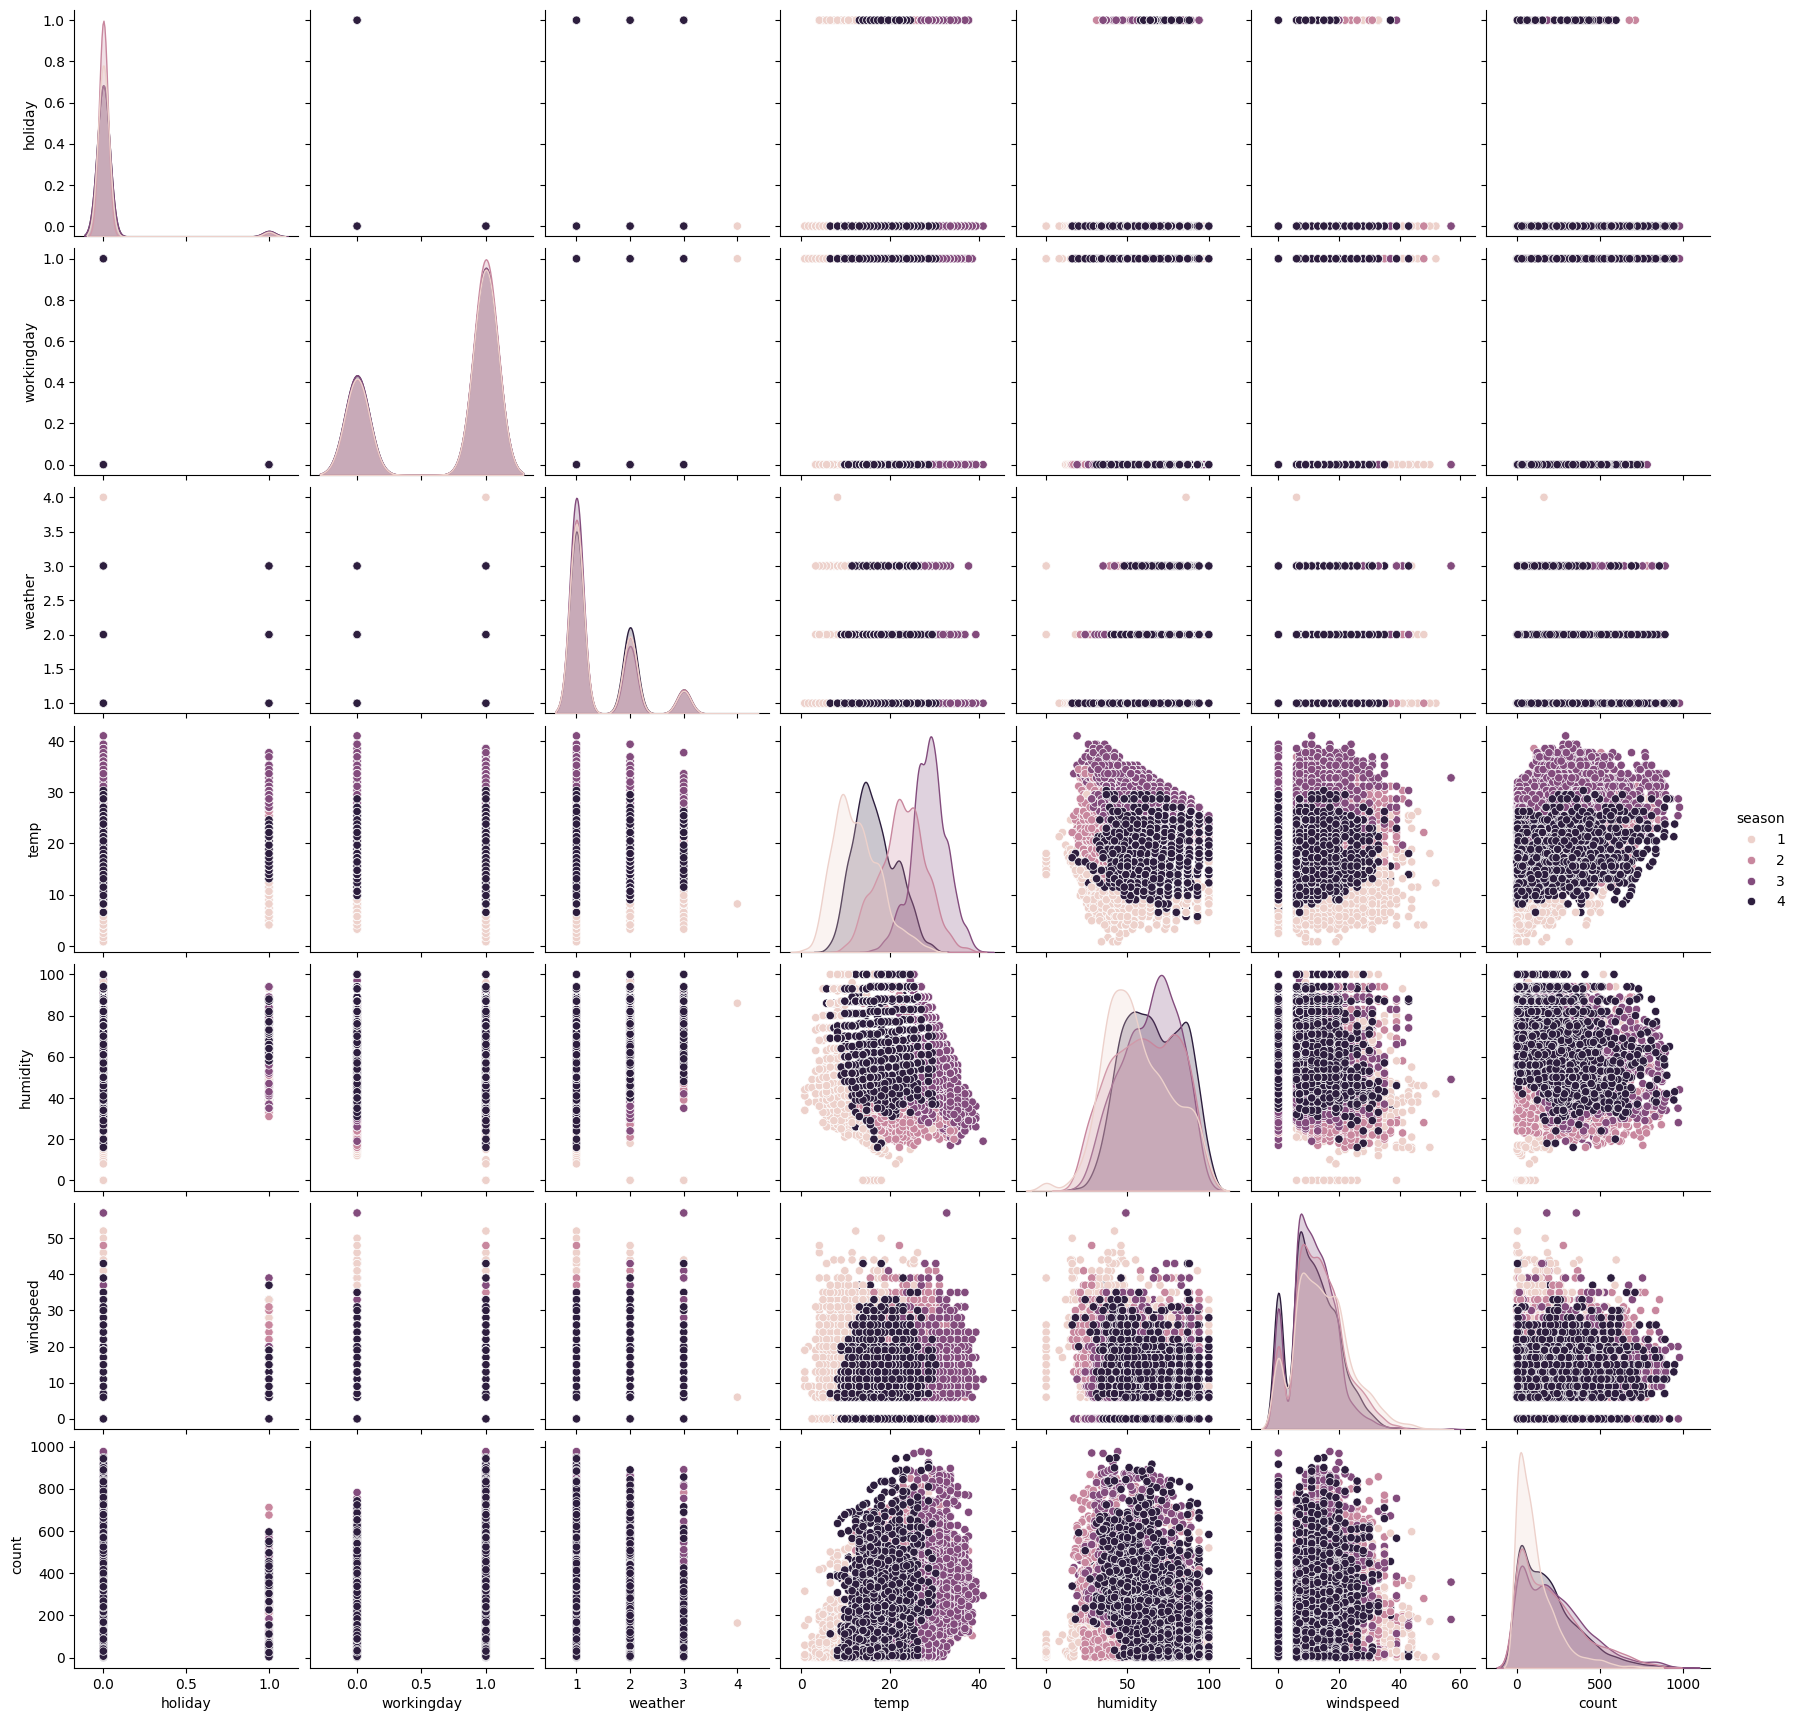

In [8]:
sns.pairplot(data=all_bikes, hue="season")

Разделим на вещественные и категориальные признаки

In [9]:
numeric_cols = ["temp", "humidity", "windspeed"]
cat_cols = [
    "season",
    "weather",
    "holiday",
    "workingday",
    "hour",
    "day",
    "month",
    "year",
    "is_working_hour",
    "time_of_day",
]
# В категориальные добавлены фичи, которые добавятся в пайплайне позже

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

Разобьем датасет на train и test

In [10]:
X = all_bikes.drop("count", axis=1)
y = all_bikes["count"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=69
)

График плотности таргета

<Axes: xlabel='count', ylabel='Density'>

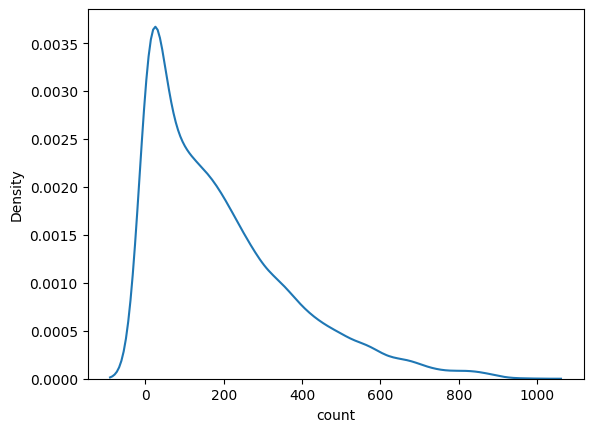

In [11]:
sns.kdeplot(data=y_train)

Посмотрим распределение таргета при логарифмизации

<Axes: xlabel='count', ylabel='Density'>

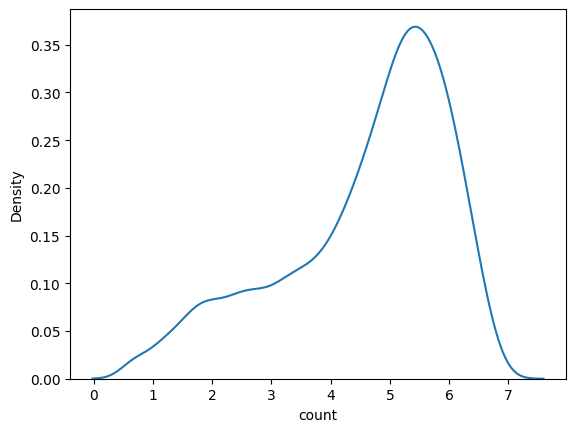

In [12]:
y1 = np.log1p(y_train)
sns.kdeplot(data=y1)

Придержим данное трансформирование таргета для пайплайна.

Построим ящики с усами для вещественных признаков, для оценивания выбросов

<Axes: >

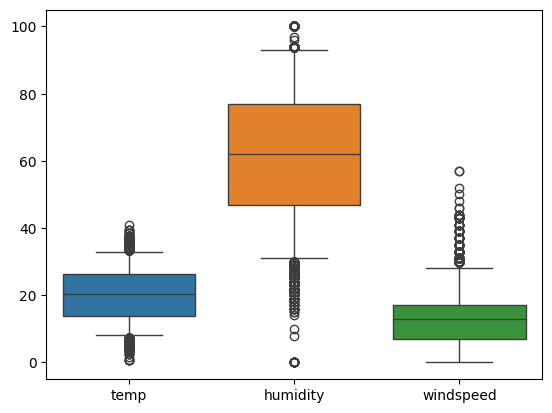

In [13]:
sns.boxplot(data=X_train[numeric_cols], whis=[5, 95])

Уберем выбросы квантилями 0.05 и 0.95. (В ходе тестов, если просто удалять все элементы, которые выходят за эти квантили, то удаляется 1/5 всего датасета. Для этого я ослабил условие. Элемент удаляется если он отличается в полтора или более раз)


In [14]:
both = pd.concat([X_train, y_train], axis=1)

for feature in ["temp", "humidity", "windspeed"]:
    Q1 = X_train[feature].quantile(0.05)
    Q3 = X_train[feature].quantile(0.95)
    both = both[(1.5 * both[feature] >= Q1) & (both[feature] <= 1.5 * Q3)]

X_train = both[X_train.columns]
y_train = both[y_train.name]



1.   Разделим "datetime" на "hour", "day", "month", "year".
2.   "time_of_day" принимает значения - ("morning", "afternoon", "evening", "night").
3.   "is_working_hour" - для учитывания рабочего времени, так как прокат может быть меньше с 9 до 17, чем в остальное время



---


Так как для обучения модели нужны категориальные и вещественные признаки, то изначальный столбец "datetime" нужно удалить. Вместо него ввести данные фичи, которые отображают его основную информацию.


Напишем класс для пайплайна, где будут добавляться фичи

In [15]:
class DatetimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_column):
        self.datetime_column = datetime_column

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        df = X.copy()

        df["hour"] = df[self.datetime_column].dt.hour
        df["day"] = df[self.datetime_column].dt.day
        df["month"] = df[self.datetime_column].dt.month
        df["year"] = df[self.datetime_column].dt.year
        df["time_of_day"] = df["hour"].apply(self.time_of_day)
        df["is_working_hour"] = df["hour"].apply(lambda x: 1 if 9 <= x <= 17 else 0)
        df = df.drop(columns=[self.datetime_column])

        return df

    def time_of_day(self, hour):
        if 6 <= hour < 12:
            return "morning"
        elif 12 <= hour < 18:
            return "day"
        elif 18 <= hour < 24:
            return "evening"
        else:
            return "night"

In [16]:
preprocessor = ColumnTransformer(
    [
        ("numeric", MinMaxScaler(), numeric_cols),
        (
            "categorical",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_cols,
        ),
    ]
)

In [17]:
pipeline = Pipeline(
    [
        ("transformer", DatetimeTransformer("datetime")),
        ("preprocessor", preprocessor),
        ("poly", PolynomialFeatures(2)),
        ("regressor", Ridge()),
    ]
)

In [18]:
target_transformer = TransformedTargetRegressor(
    regressor=pipeline, func=np.log1p, inverse_func=np.expm1
)

param_grid = {"regressor__regressor__alpha": [14.444444444444445]}

clf = GridSearchCV(target_transformer, param_grid, cv=5)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
r2 = r2_score(y_test, preds)
root = root_mean_squared_error(y_test, preds)
print(r2, root)

y_train_pred = clf.predict(X_train)
r2_1 = r2_score(y_train, y_train_pred)
root_1 = root_mean_squared_error(y_train, y_train_pred)
print(r2_1, root_1)

0.9254026513840277 49.5712709807381
0.9477282141691545 41.42232853972527


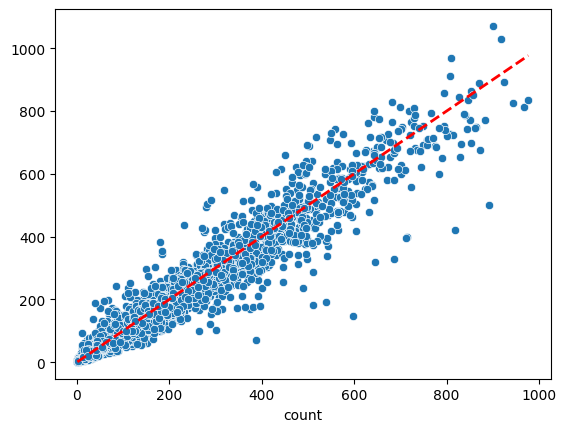

In [19]:
sns.scatterplot(x=y_test, y=preds)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
)
plt.show()

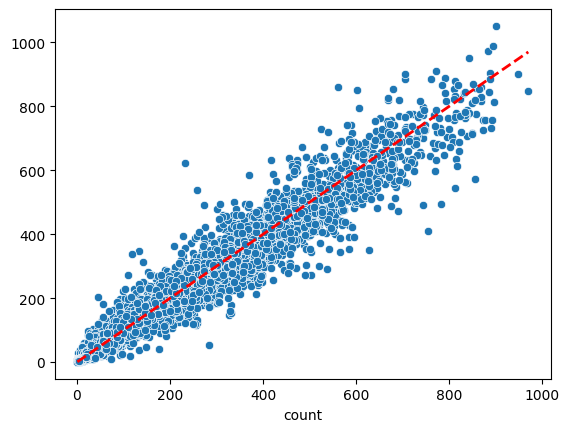

In [20]:
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    color="red",
    linestyle="--",
    linewidth=2,
)
plt.show()